# Rank TFs from pairwise comparison

## Motivation

We expected to see TFs with high regulatory activity have higher expression changes when comparing two cell types or tissues. From the scatter plot, we observed many TFs do not follow this trend. One problem is that y-axis represents the differences in target counts, which is not informative to show how the TF target genes differ across tissues or cell types. Due to the large differences in cell type compositions across tissues, we need to take a different strategy to perform differential analyses, such as topic modeling.

## TO DO LIST

* Identify more candidate TFs with a different metric based on the scatter plot 
    - [x] Make dot color vary according to number of target genes not shared on the scatter plot
* Identify more candidate TFs by ranking them according to number of target genes not shared 
    - [x] Check the histogram of the number of target genes not shared for TFs with small changes in differential regulation and at varying differential expression levels.
* Check whether TF markers are indeed unique to lung immune cells 
    - [ ] Use randomly picked TFs expressed in all cell types to see their regulatory activity

### Choose the sparsity level based on the statistics of lung GRN
* Majority of TFs have hundreds of target genes. Compared with other cell types, Naive B cells have more TFs with relatively large number target genes.
* The distribution of number of target genes across TFs did not change much with the increase in the sparsity level.
* With the sparsity level increased to 0.015, we see the number of TFs that target each gene has been over 5 across cell types for lung GRNs.

#### Sparsity=0.01

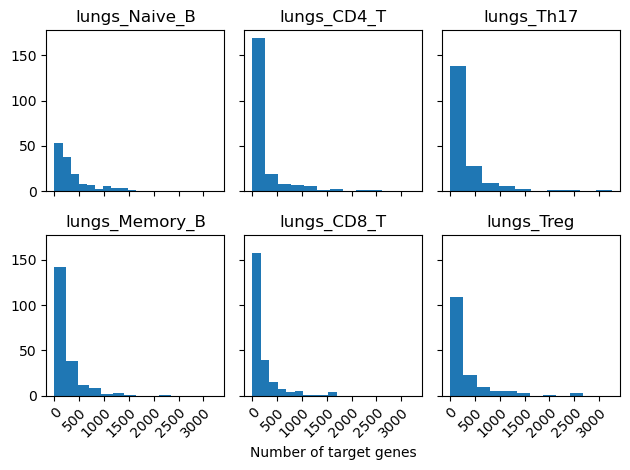

In [27]:
make_group_hist(d_targets, "Number of target genes", range(0, 3500, 500))

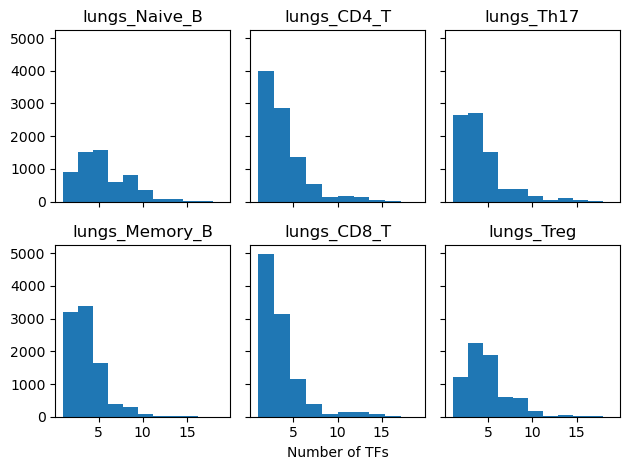

In [15]:
make_group_hist(d_regs, "Number of TFs")

#### Sparsity=0.015

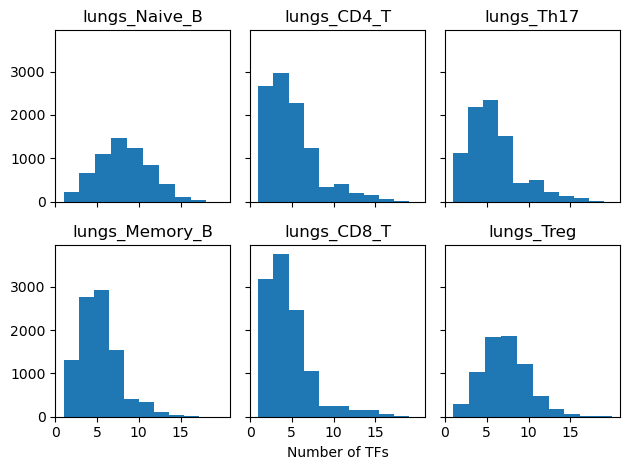

In [17]:
make_group_hist(d_regs, "Number of TFs", range(0, 20, 5))

### Visualize pairwise comparison results colored by the number of unique target genes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dictys.plot.static import compute_spec
from dictys.plot import dotplot
from dictys.net import network
import pandas as pd
import seaborn as sns
import itertools
#Load networks
d0=network.from_file("/home/jinggu/scratch/projects/dictys/output/static.h5")

#Rename cell subsets
d0.rename('s',{
    'Subset1':'lungs_Memory_B','Subset2':'lungs_Naive_B',
    'Subset3':'lungs_Treg','Subset4':'lungs_CD4_T','Subset5':'lungs_CD8_T',
    'Subset6':'lungs_Th17','Subset7':'spleens_Memory_B','Subset8':'spleens_Naive_B','Subset9':'spleens_Treg',
    'Subset10':'spleens_CD4_T', 'Subset11':'spleens_CD8_T', 'Subset12':'spleens_Th17'})

In [2]:
# retrieve_edges_GRNs
from functools import partial
import numpy as np
from dictys.net.layout import _fruchterman_reingold
from dictys.net import stat

def retrieve_edges_GRNs(state, sparsity_value=0.01):
    pts=np.array([d0.sdict[state]])
    stat1_net=stat.net(d0)
    stat1_netbin=stat.fbinarize(stat1_net,sparsity=sparsity_value)
    #Subnetwork
    stat1_subnet,stat1_subnetbin=stat1_net,stat1_netbin
    transformation=lambda x:x
    stat1_subnet_trunc=stat.function(lambda *x:transformation(x[0]*x[1]),
                                     [stat1_subnet,stat1_subnetbin],
                                     names=stat1_subnet.names)
    edges=stat1_subnet_trunc.compute(pts)[:,:,0]
    t1=np.nonzero(edges)
    edges=pd.DataFrame([stat1_subnet_trunc.names[0][t1[0]],
                        stat1_subnet_trunc.names[1][t1[1]],
                        edges[t1[0],t1[1]]],index=['Regulator','Target','Strength']).T
    return(edges)

def get_unique_targets_diff(data, states):

    edge0=retrieve_edges_GRNs(states[0], sparsity_value=0.015)
    edge1=retrieve_edges_GRNs(states[1], sparsity_value=0.015)
    target_set0 = edge0.groupby("Regulator", group_keys=True)[["Target"]].apply(lambda x: set(x.iloc[:,0]))
    target_set1 = edge1.groupby("Regulator", group_keys=True)[["Target"]].apply(lambda x: set(x.iloc[:,0]))

    d_uniq_diff={}
    
    for i in list(data.index):
        if i in target_set0 and i in target_set1:
            union_set=target_set0[i].union(target_set1[i])
            overlaps=target_set0[i].intersection(target_set1[i])
            uniq_set=union_set.difference(overlaps)
            uniq_set0= len(target_set0[i].intersection(uniq_set))
            uniq_set1= len(target_set1[i].intersection(uniq_set))
            d_uniq_diff[i] = uniq_set1/uniq_set0
        else:
            d_uniq_diff[i]=np.nan
    return d_uniq_diff


def get_unique_targets_stats(data, states):

    edge1=retrieve_edges_GRNs(states[0], sparsity_value=0.015)
    edge2=retrieve_edges_GRNs(states[1], sparsity_value=0.015)
    target_set1 = edge1.groupby("Regulator", group_keys=True)[["Target"]].apply(lambda x: set(x.iloc[:,0]))
    target_set2 = edge2.groupby("Regulator", group_keys=True)[["Target"]].apply(lambda x: set(x.iloc[:,0]))

    d_uniq={}
    d_union={}
    d_prop={}
    
    for i in list(data.index):
        if i in target_set1 and i in target_set2:
            union_set=target_set1[i].union(target_set2[i])
            overlaps=target_set1[i].intersection(target_set2[i])
            uniq_set=union_set.difference(overlaps)
            d_union[i]=len(union_set)
            d_uniq[i]=len(uniq_set)
        elif i in target_set1 and i not in target_set2:
            d_uniq[i]=len(target_set1[i])
            d_union[i]=len(target_set1[i])
        elif i in target_set2 and i not in target_set1:
            d_uniq[i]=len(target_set2[i])
            d_union[i]=len(target_set2[i])
        else:
            d_uniq[i]=np.nan
            d_union[i]=np.nan
            
        d_prop[i]=d_uniq[i]/d_union[i]

    return([d_uniq, d_prop, d_union])

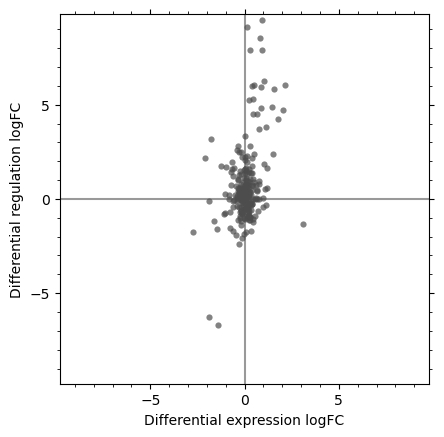

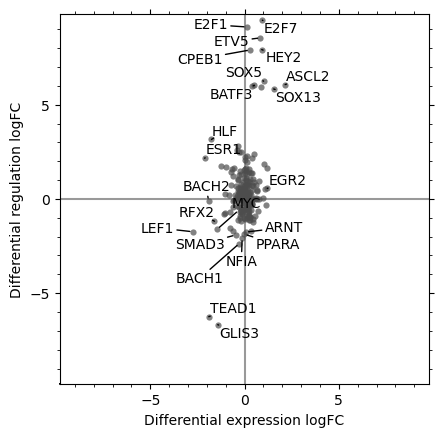

In [63]:
from dictys.plot.static import fig_diff_scatter,fig_diff_rank

#Cell type/state names to compare in (reference, alternative) format. Here it is Treg v.s. B.
states=('lungs_CD4_T','lungs_CD8_T')

fig=plt.figure()
ax=fig.add_subplot(111)
data=fig_diff_scatter(d0,ax,states, sparsity=0.015)

#Draw figure
#Number of top genes to annotate on each side
ntop=8
#Find genes to annotate
annotate=np.partition(data.values,[ntop-1,-ntop],axis=0)
annotate=((data.values<=annotate[ntop-1])|(data.values>=annotate[-ntop])).any(axis=1)
annotate=list(data.index[annotate])
fig=plt.figure()
ax=fig.add_subplot(111)
data=fig_diff_scatter(d0,ax,states, annotate=annotate, cut_ntarget=50, sparsity=0.015)

In [3]:
# Edited the original code of scatter plots by varying dot colors according to #unique genes
from grn_plots import fig_diff_scatter

**Scatter plots for differential expression and regulation across cell types**

Color scheme:
Grey color means for that specific TF there were no target genes found in one of the cell types. For instance, ETV7 was found to have no target genes in lung Treg T cells, so number of target genes not shared cannot be counted and thus given a grey color.|

/home/jinggu/jinggu/env/dictys/lib/python3.9/site-packages/matplotlib/collections.py:1080: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "
/home/jinggu/jinggu/env/dictys/lib/python3.9/site-packages/matplotlib/collections.py:1080: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "
/home/jinggu/jinggu/env/dictys/lib/python3.9/site-packages/matplotlib/collections.py:1080: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


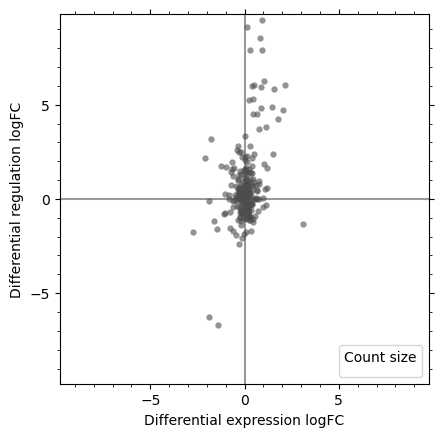

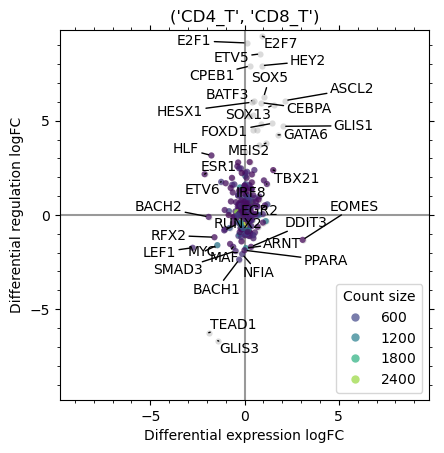

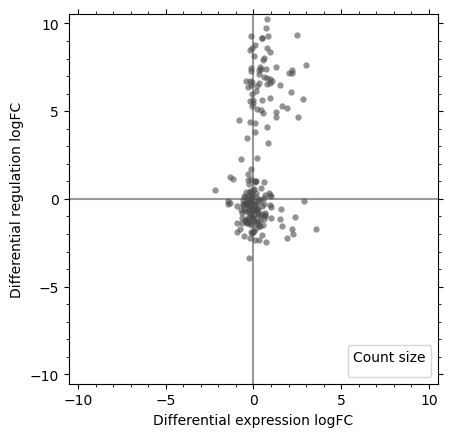

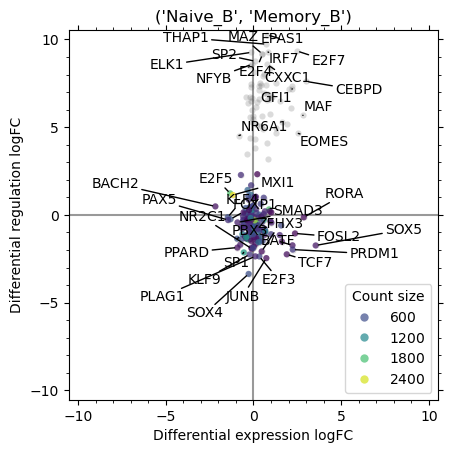

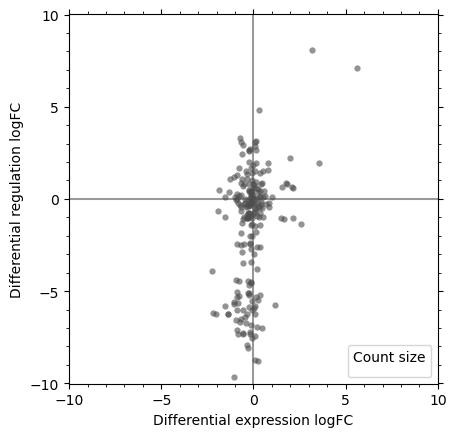

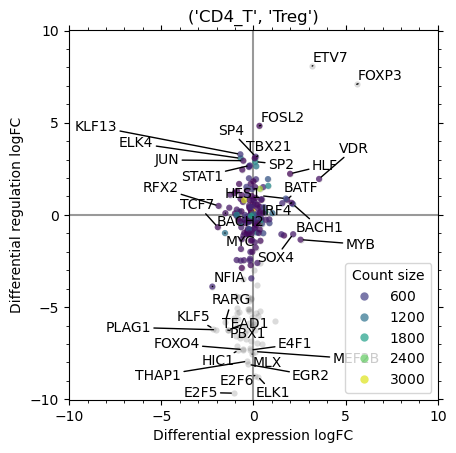

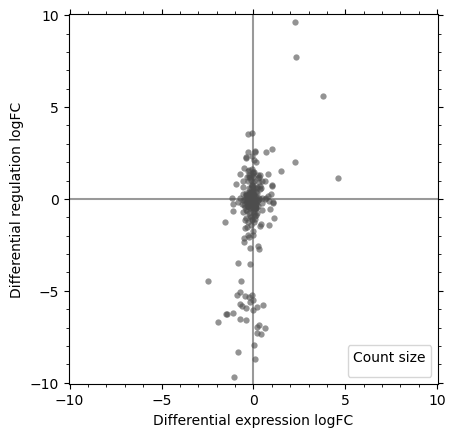

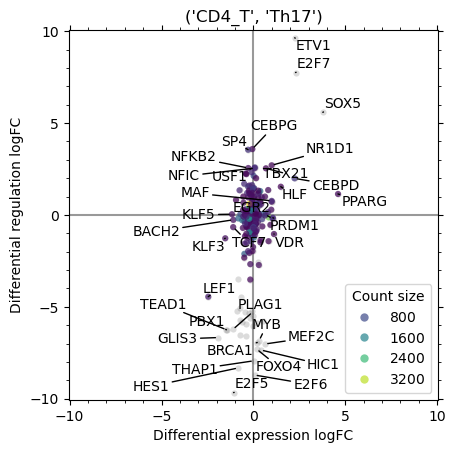

In [10]:
ct_pairs=[("CD4_T", "CD8_T"),
          ("Naive_B", "Memory_B"),
          ("CD4_T", "Treg"),
          ("CD4_T", "Th17")
         ]
for ct in ct_pairs:
    states=[f"lungs_{i}" for i in ct]
    fig=plt.figure()
    ax=fig.add_subplot(111)
    data=fig_diff_scatter(d0,ax,states)

    ntop=10

    #Color dots by number of unique target genes
    uniq_stats=get_unique_targets_stats(data, states)
    new_data=pd.concat([data, pd.DataFrame({"DR_UniqTargets":uniq_stats[0]})], axis=1)
    # new_data=pd.concat([data["DE_logFC"], pd.DataFrame({"DR_logFC": uniq_stats[1],
    #                                                 "DR_UniqTargets":uniq_stats[0]})], axis=1)
    ka_update=dict({'s':20,
                    'c':new_data["DR_UniqTargets"],
                    'lw':0,'alpha':0.7})
    
    #Find genes to annotate
    data.dropna(inplace=True) # remove TFs with NA
    annotate=np.partition(data.values,[ntop-1,-ntop],axis=0)
    annotate=((data.values<=annotate[ntop-1])|(data.values>=annotate[-ntop])).any(axis=1)
    annotate=list(data.index[annotate])
    
    fig=plt.figure()
    ax=fig.add_subplot(111)
    ax.set_title(ct)
    data=fig_diff_scatter(d0,ax,states, annotate=annotate, **ka_update)

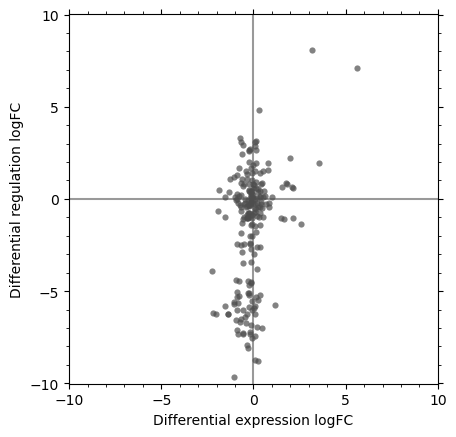

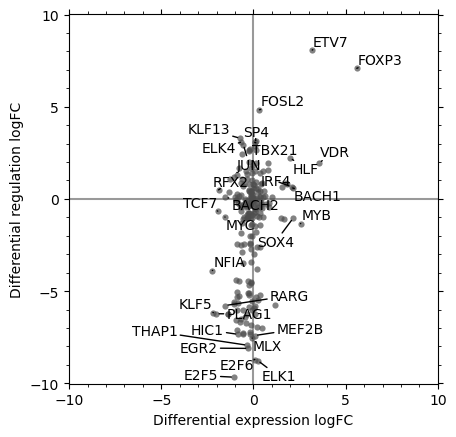

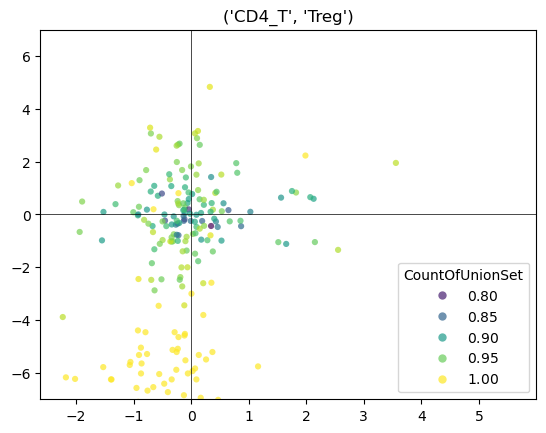

In [92]:
from dictys.plot.static import fig_diff_scatter,fig_diff_rank

ct_pairs=[("CD4_T", "CD8_T"),
          ("Naive_B", "Memory_B"),
          ("CD4_T", "Treg"),
          ("CD4_T", "Th17")
         ]

for ct in ct_pairs[2:3]:
    states=[f"lungs_{i}" for i in ct]

    fig=plt.figure()
    ax=fig.add_subplot(111)
    data=fig_diff_scatter(d0,ax,states, sparsity=0.015)
    #Draw figure
    #Number of top genes to annotate on each side
    ntop=8
    #Find genes to annotate
    annotate=np.partition(data.values,[ntop-1,-ntop],axis=0)
    annotate=((data.values<=annotate[ntop-1])|(data.values>=annotate[-ntop])).any(axis=1)
    annotate=list(data.index[annotate])
    fig=plt.figure()
    ax=fig.add_subplot(111)
    data=fig_diff_scatter(d0,ax,states, annotate=annotate, sparsity=0.015)

    #Color dots by number of unique target genes
    uniq_stats=get_unique_targets_stats(data, states)
    new_data=pd.concat([data, pd.DataFrame({"DR_JaccardIndex":uniq_stats[1],
                                            "DR_Union": uniq_stats[2]})], axis=1)
    
    fig=plt.figure()
    ax=fig.add_subplot(111)
    ax.axvline(c='black', lw=0.5)
    ax.axhline(c='black', lw=0.5)
    p = ax.scatter(x=new_data["DE_logFC"], 
                   y=new_data["DR_logFC"],
                   s=20,
                   c=new_data["DR_JaccardIndex"],
                   lw=0,alpha=0.7
               )
    ax.legend(*p.legend_elements(num=6), loc="lower right", title="CountOfUnionSet")
    ax.set_title(ct)
    ax.set_ylim([-7,7])

In [146]:
ntop=10
#annotate=np.partition(data.values,[ntop-1,-ntop],axis=0)
#annotate=(data.values<=annotate[ntop-1]).any(axis=1)|(data.values>=annotate[-ntop])).any(axis=1)
annotate=(new_data["DR_logFC"].abs()<=2) & (new_data["DR_JaccardIndex"] >=0.97) | (new_data.index=="FOXP3")
annotations=data.index[annotate]
#annotations=['SMAD3','TCF7','CEBPA','BACH2','LEF1','RUNX2']

In [50]:
from adjustText import adjust_text

(0.9, 1.01)

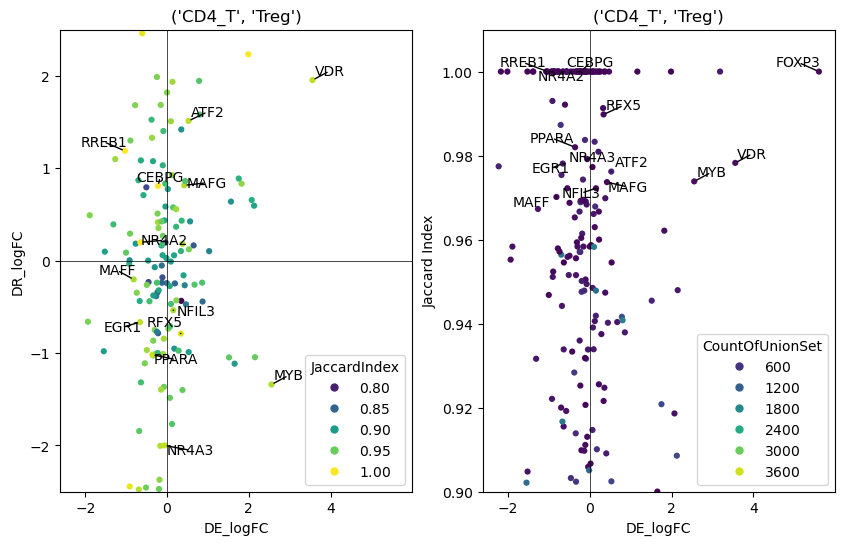

In [151]:
    fig=plt.figure(figsize=[10, 6])
    ax=fig.add_subplot(121)
    ax.axvline(c='black', lw=0.5)
    ax.axhline(c='black', lw=0.5)
    p = ax.scatter(x=new_data["DE_logFC"], 
                   y=new_data["DR_logFC"],
                   s=20,
                   c=new_data["DR_JaccardIndex"],
                   lw=0,alpha=1
               )
    ax.legend(*p.legend_elements(num=6), loc="lower right", title="JaccardIndex")
    ax.set_title(ct)
    ax.set(xlabel="DE_logFC", ylabel="DR_logFC", title=ct)
    #adjust text to avoid overlapping
    texts=[ax.annotate(text, xy=(xi,yi), 
                       xytext=(1.5, 1.5), 
                       textcoords='offset points', 
                       arrowprops=dict(arrowstyle= "-",
                                    color='k',lw=1)
                  ) for xi, yi, text in zip(new_data[annotate]["DE_logFC"],
                                            new_data[annotate]["DR_logFC"], annotations)]
    adjust_text(texts)
    #ax.set_xlim([-2,2])
    ax.set_ylim([-2.5, 2.5])

    ax=fig.add_subplot(122)
    ax.axvline(c='black', lw=0.5)
    #ax.axhline(c='black', lw=0.5)
    p = ax.scatter(x=new_data["DE_logFC"], 
                   y=new_data["DR_JaccardIndex"],
                   s=20,
                   c=new_data["DR_Union"],
                   lw=0,alpha=1
               )
    ax.legend(*p.legend_elements(num=6), loc="lower right", title="CountOfUnionSet")
    ax.set(xlabel="DE_logFC", ylabel="Jaccard Index", title=ct)
    texts=[ax.annotate(text, xy=(xi,yi), 
                       xytext=(1.5, 1.5), 
                       textcoords='offset points', 
                       arrowprops=dict(arrowstyle= "-",
                                     color='k',lw=1)
                  ) for xi, yi, text in zip(new_data[annotate]["DE_logFC"],
                                            new_data[annotate]["DR_JaccardIndex"], annotations)]
    adjust_text(texts)
    #ax.set_xlim([-2,2])
    ax.set_ylim([0.9, 1.01])

We saw a few data points with small differential regulation values but high number of unique genes. 

### Identify more candidate TFs by number of unique target genes

Histogram for number of unique target genes for TFs which were identified in both tissues at varying cutoffs for differential expression. Instead of using a hard cutoff for differential regulation, here I filtered TFs by requiring them to have target genes in both tissues.  

* Some TFs with large number of genes not shared cross tissues remain at a more stringent cutoff for differetial DE
* Overall, around 10 TFs with DE greater than 1.0 have large number target genes not shared. 

/home/jinggu/jinggu/env/dictys/lib/python3.9/site-packages/matplotlib/collections.py:1080: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "
/home/jinggu/jinggu/env/dictys/lib/python3.9/site-packages/matplotlib/collections.py:1080: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "
/home/jinggu/jinggu/env/dictys/lib/python3.9/site-packages/matplotlib/collections.py:1080: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "
/home/jinggu/jinggu/env/dictys/lib/python3.9/site-packages/matplotlib/collections.py:1080: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via t

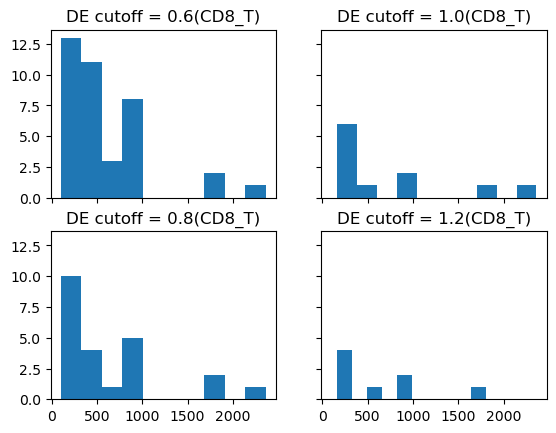

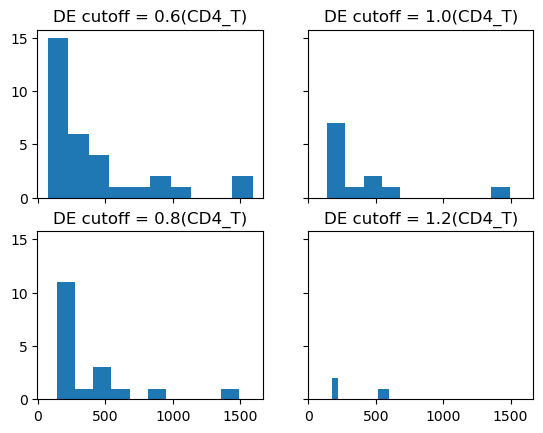

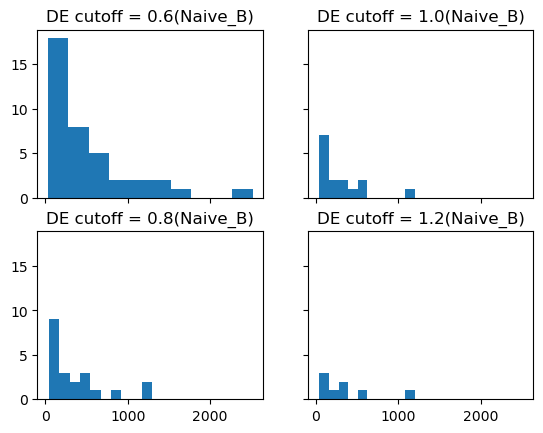

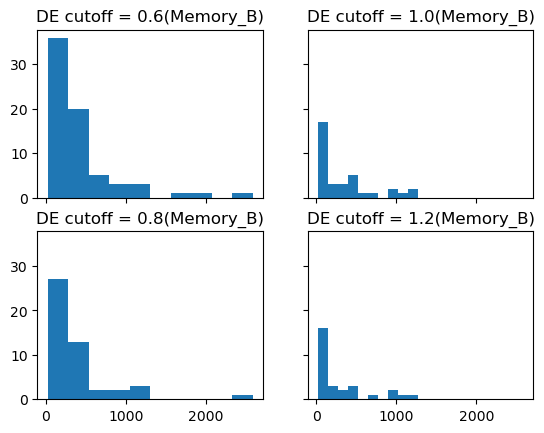

In [54]:
ct_order=["CD8_T", "CD4_T", "Naive_B", "Memory_B"]
for ct in ct_order:
    states=[f"spleens_{ct}", f"lungs_{ct}"]
    DE_cutoff=[0.6, 0.8, 1.0, 1.2] #at varying DE cutoff
    #DR_cutoff=1.5
    data=fig_diff_scatter(d0,ax,states)
    uniq_stats=get_unique_targets_stats(data, states)
    new_data=pd.concat([data, pd.DataFrame({"DR_UniqTargets":uniq_stats[0]})], axis=1)

    fig,axs = plt.subplots(2,2, sharey=True, sharex=True)
    for i in range(0,len(DE_cutoff),2):
    
        #df=pd.DataFrame({"DR_le": new_data["DR_UniqTargets"].abs()<=DR_cutoff,
        df=pd.DataFrame({"DR_le": -np.isnan(new_data["DR_UniqTargets"]),
                         "DE_ge": new_data["DE_logFC"].abs()>=DE_cutoff[i]})
        tfs_toplot=df.loc[df.all(axis="columns")==True].index   
        axs[0,i//2].hist(new_data.loc[new_data.index.isin(tfs_toplot), "DR_UniqTargets"],
                bins=10)
        axs[0,i//2].set_title(f"DE cutoff = {DE_cutoff[i]}({ct})")
        
        #df=pd.DataFrame({"DR_le": new_data["DR_logFC"].abs()<=DR_cutoff,
        df=pd.DataFrame({"DR_le": -np.isnan(new_data["DR_UniqTargets"]),
                         "DE_ge": new_data["DE_logFC"].abs()>=DE_cutoff[i+1]})
        tfs_toplot=df.loc[df.all(axis="columns")==True].index  
        
        axs[1,i//2].hist(new_data.loc[new_data.index.isin(tfs_toplot), "DR_UniqTargets"],
                bins=10)
        axs[1,i//2].set_title(f"DE cutoff = {DE_cutoff[i+1]}({ct})")


#### Ranking TFs based on the number of unique target genes

The first and third barplots are the same. The y-axis should be number of unique target genes. The second plot is based on ranking TFs by logFC of differential expression.

**Barplots labeled by top 20 TFs ranked by number of unique genes**

filter criteria: |DE_logFC| >=1.0

In [18]:
ct="Naive_B"
states=[f"spleens_{ct}", f"lungs_{ct}"]
data=fig_diff_scatter(d0,ax,states)
uniq_stats=get_unique_targets_stats(data, states)
new_data=pd.concat([data, pd.DataFrame({"DR_UniqTargets":uniq_stats[0]})], axis=1)
new_data["DR_logFC"] = new_data["DR_UniqTargets"]

In [24]:
new_data["DR_logFC"] = new_data["DR_UniqTargets"]
new_data.dropna(inplace=True)

,DE_logFC,DR_logFC,DR_UniqTargets
AHR,0.320731,1385.0,1385.0
ARNT,-0.104640,1438.0,1438.0
ATF1,-0.756603,715.0,715.0
ATF2,-0.475882,319.0,319.0
ATF3,0.544833,766.0,766.0


In [40]:
annot=new_data[new_data["DE_logFC"].abs()>=0.8].sort_values(by="DR_logFC", ascending=False).index[0:20]

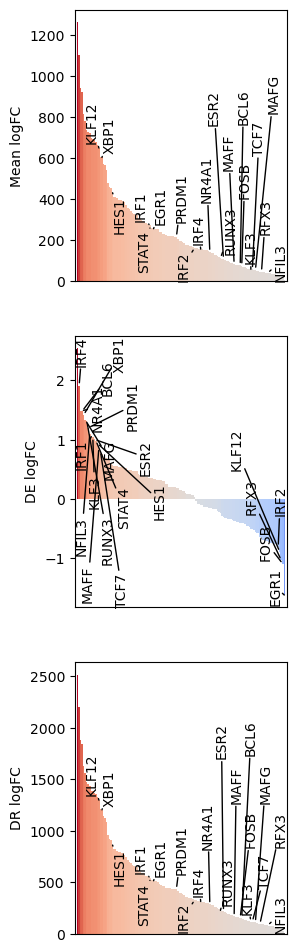

In [41]:
p2=fig_diff_rank(new_data, figsize=(0.02,4), annotate=annot)

**Same barplots labeled by top 20 TFs ranked by logFC of differential regulation**

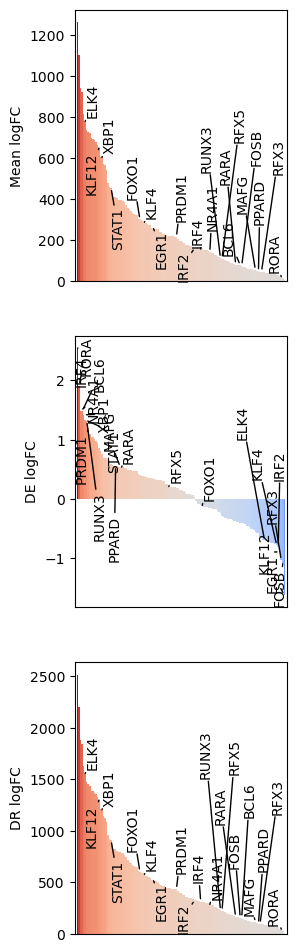

In [39]:
ntop=10
annotate=np.partition(data.values,[ntop-1,-ntop],axis=0)
annotate=((data.values<=annotate[ntop-1])|(data.values>=annotate[-ntop])).any(axis=1)
annotate=list(data.index[annotate])
commons=set(annotate).intersection(new_data.index)
#new_data["DR_logFC"] = new_data["DR_UniqTargets"]
p3=fig_diff_rank(new_data, figsize=(0.02,4), annotate=commons)

In [46]:
annot.difference(commons)

Index(['FOXO1', 'FUBP1', 'HIF1A', 'KLF12', 'KLF3', 'LEF1', 'MAF', 'MYC',
       'NFAT5', 'NR4A1', 'PLAG1', 'PRDM1', 'RFX2', 'RUNX3', 'STAT4', 'TFEB'],
      dtype='object')

In [41]:
annot.intersection(commons)

Index(['EGR1', 'ESR2', 'TGIF1', 'ESR1'], dtype='object')

Ranking TFs by number of unique genes across tissue enables us to identify more TFs that were not found merely by number of target genes. 